In [2]:
import jax.numpy as jnp
import jax.random as jrand
import jax.numpy.linalg as jlin
import matplotlib.pyplot as plt

from jax import grad

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

In [ ]:
plt.style.use("ggplot")
key = jrand.PRNGKey(0)

# Simple data generation

In [ ]:
def f(x):
    return jnp.sin(jnp.pi*x/2) + 0.5*jnp.sin(2*jnp.pi*x)

d_f = grad(f)

In [ ]:
n_test = 200

X_test = jnp.linspace(0, 1, n_test)
y_test = f(X_test)

In [ ]:
# Noisy training dataset
n_train = 20
noise = 0.05

X_train = jnp.linspace(0, 1, n_train)
y_train = f(X_train) + noise*jrand.normal(key, shape=(n_train,))

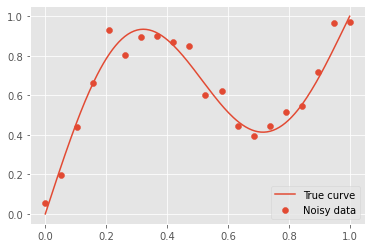

In [ ]:
plt.plot(X_test, y_test, label="True curve")
plt.scatter(X_train, y_train, label="Noisy data")
plt.legend()

# GP Regression Prior

In [ ]:
log_sig = jnp.log(0.01) 
log_params = {
    "nu": jnp.log(1),
    "l": jnp.log(1)
}

# Params in log-scale!
def rbf_kernel(log_params, x, y):
    return jnp.exp( log_params["nu"] - (x-y)**2 * jnp.exp(-2*log_params["l"]) /2  )

# Variational inference

In [ ]:
# Z is the set of inducing points
def elbo(log_params, log_sig, Z, X, y):
    n_inducing = len(Z)
    sig = jnp.exp(log_sig)

    # Kernel matrixes
    Knn = jnp.zeros((n_train, n_train))
    Kmn = jnp.zeros((n_inducing, n_train))
    for i in range(n_train):
        for j in range(i+1):
            Knn[i,j] = rbf_kernel(log_params, X[i], X[j])
            Knn[j,i] = Knn[i,j]
        
        for j in range(n_inducing):
            Kmn[j,i] = rbf_kernel(log_params, X[i], Z[j])
    
    Kmm = jnp.zeros((n_inducing, n_inducing))
    for i in range(n_inducing):
        for j in range(i+1):
            Kmm[i,j] = rbf_kernel(log_params, Z[i], Z[j])
            Kmm[j,i] = Kmm[i,j]

    # Computation
    L = jlin.cholesky(Kmm)
    A = jlin.solve(sig*L, Kmn)
    S = A @ A.T
    B = jnp.identity(n_inducing) + S
    L_B = jlin.cholesky(B)
    c = jlin.solve(sig*L_B, A @ y)